# Master Toy Playground

## Imports, Utility Functions

Load dependancy modules

In [11]:
from pandas import DataFrame
from polars import from_pandas
from cv2 import imread, imshow, waitKey, destroyAllWindows
from cv2 import cvtColor, COLOR_BGR2RGB
from glob import glob
from pathlib import Path
from re import match
from time import perf_counter
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

Standardize file naming to english to ensure the opencv workflow

In [2]:
def transliterate(dir_path):
    from subprocess import call
    from os import walk
    i = 0
    for root,dirs,files in walk(dir_path):
        print(root)
        for file in files:
            path = Path(f'{root}/{file}')
            if (not match(r'[a-zA-Z0-9_\. -]+', file)) & (match(r'.+\.(jpg|JPG|jpeg)', file) is not None):
                i+=1
                path.rename(f"{root}/IMG_{round(perf_counter())}_{i}.jpg") # arbitrary name: the key is guarnteed to be unique
transliterate("cats+dogs")

cats+dogs


### Load images from a directory utility function

In [3]:
def fetch_images(dir_path, ext='jpg'):
    return glob(f'{dir_path}/*.{ext}')

## The workflow

### Load the images - look at the shape statistics, see the memory usage

#### Look at the raw data

In [4]:
filenames = fetch_images("cats+dogs")

In [14]:
df = DataFrame({"img": filenames}).astype({'img': 'string'})
df['width'] = df.img.progress_apply(lambda x: imread(x).shape[1]).astype('int32')
df['height'] = df.img.progress_apply(lambda x: imread(x).shape[0]).astype('int32')

  0%|          | 0/146 [00:00<?, ?it/s]

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


  0%|          | 0/146 [00:00<?, ?it/s]

Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG
Invalid SOS parameters for sequential JPEG


In [15]:
# df = from_pandas(df)

We can see that the data that was provided / extracted immidiatly is not labeled - so we need to make clustering manually or by some neat ML algorithm, and check the correctness

#### Now let's look at some statistics about these pictures:

width  height
min    304     285
25%   1164     929
50%   1413    1173
75%   2133    2055
max   4248    5664

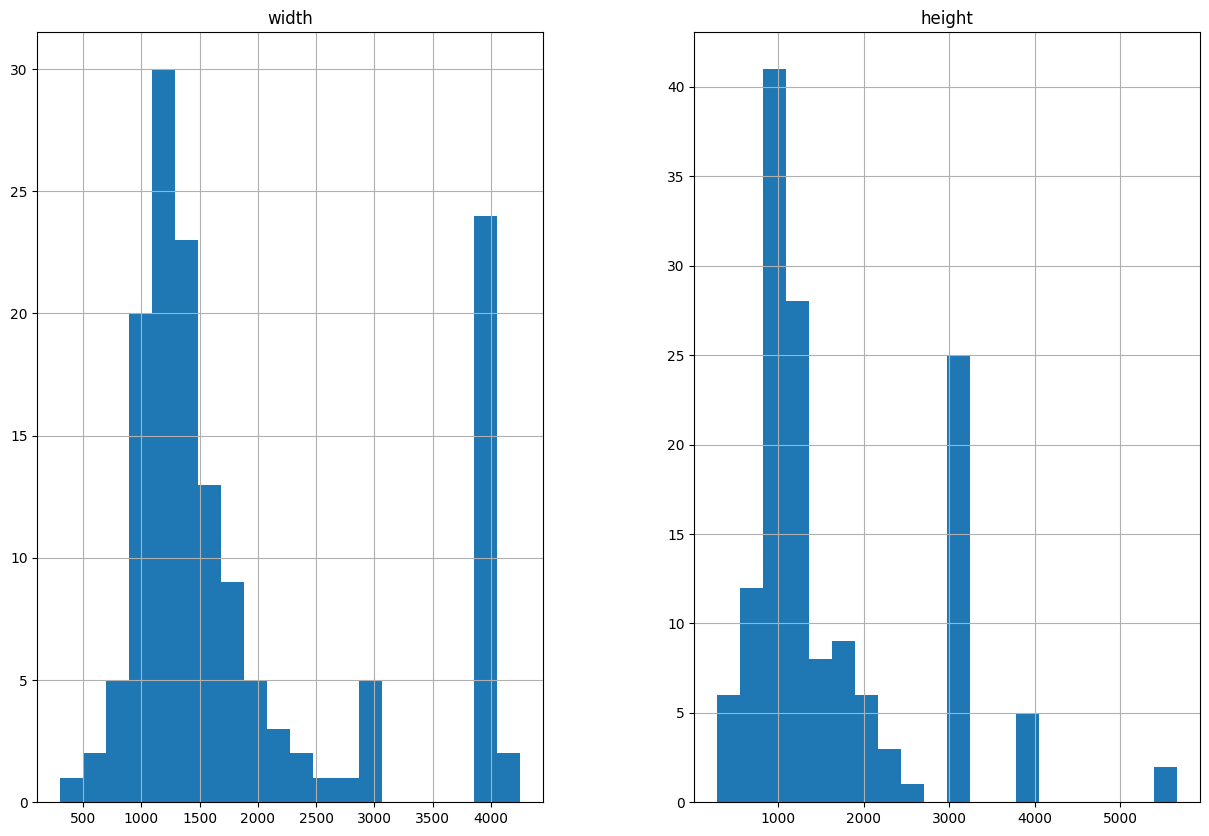

In [16]:
statistics = df[['width','height']].describe()
statistics = statistics[~statistics.index.isin(['count','mean','std'])].astype('int32')
df[['width','height']].hist(bins=20, figsize=(15,10))
display(statistics)

In [10]:
df['img'].info() # 123 pictures, median size 1315x1094 px
print()
df[['width', 'height']].info()

<class 'pandas.core.series.Series'>
RangeIndex: 146 entries, 0 to 145
Series name: img
Non-Null Count  Dtype 
--------------  ----- 
146 non-null    string
dtypes: string(1)
memory usage: 1.3 KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   width   146 non-null    int32
 1   height  146 non-null    int32
dtypes: int32(2)
memory usage: 1.3 KB


### Now, Let's take a general look at the images in a dataset, and a look at the statistics benchmark images

In [17]:
def sample_n_images(df, n=10):
    from numpy.random import choice, seed as np_seed
    np_seed(0)
    plt.close()
    for i in list(choice(df.index, n, replace=False)):
        plt.figure(i)
        plt.imshow(cvtColor(imread(df.img[i]), COLOR_BGR2RGB))
    plt.show()

In [18]:
def statistics_benchmark_images(df, statistics):
    for _, (w,h) in enumerate(zip(statistics.width, statistics.height)):
        i = df[(df.width==w) | (df.height==h)].index
        plt.close()
        if len(i) >= 1:
            for j in range(len(i)):
                plt.figure(_+j)
                plt.imshow(cvtColor(imread(df.img[i[j]]), COLOR_BGR2RGB))
        plt.show()

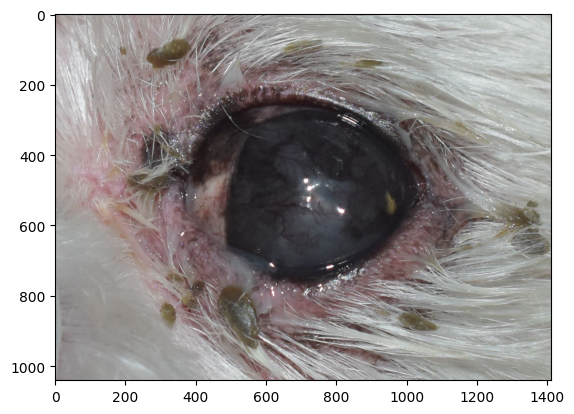

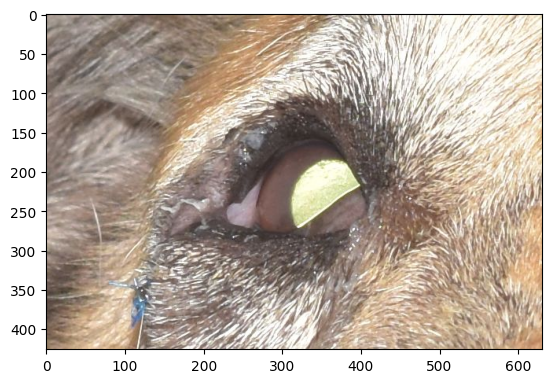

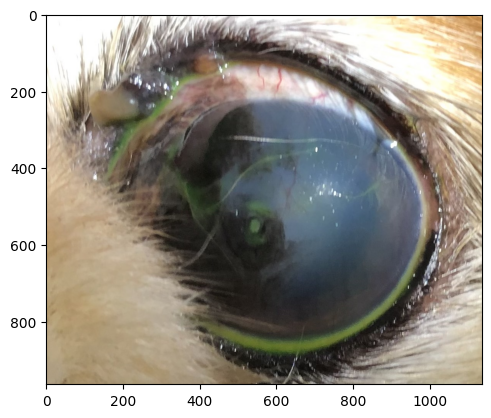

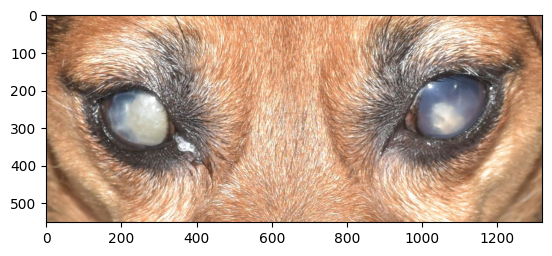

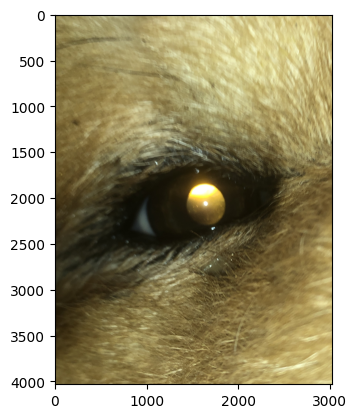

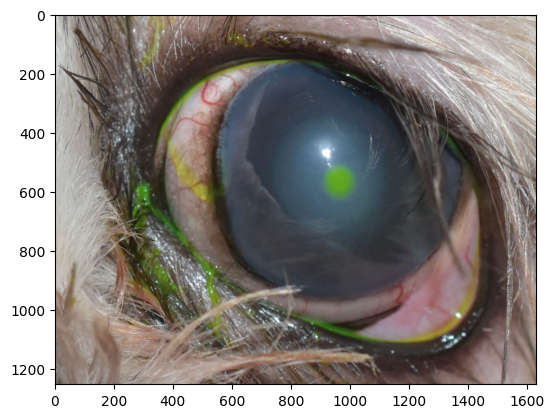

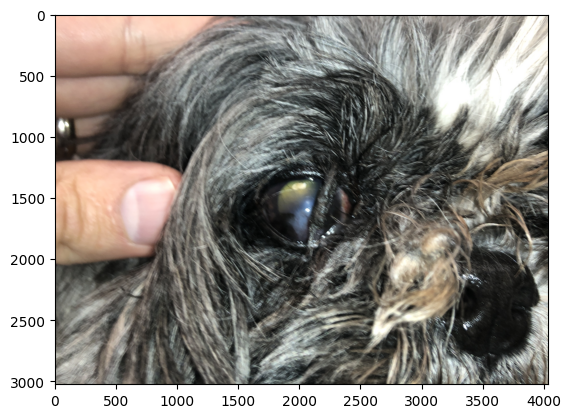

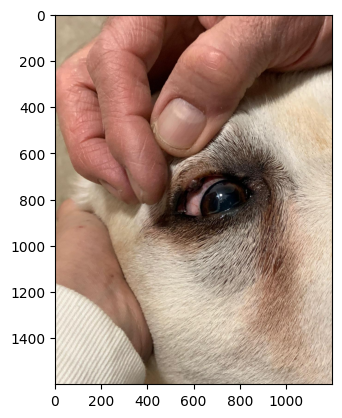

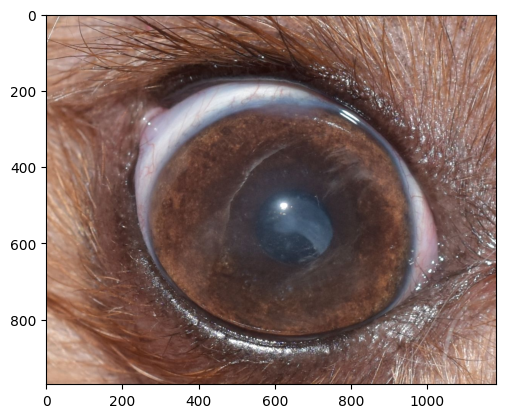

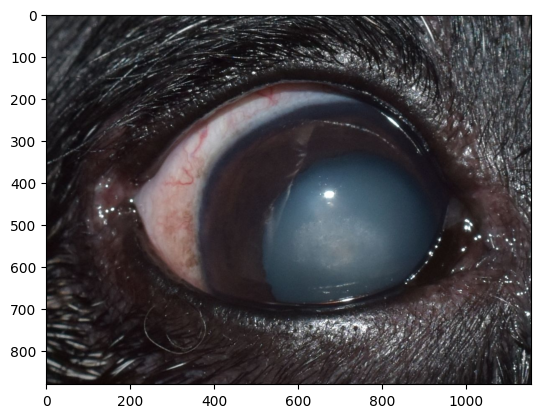

In [19]:
sample_n_images(df, 10)

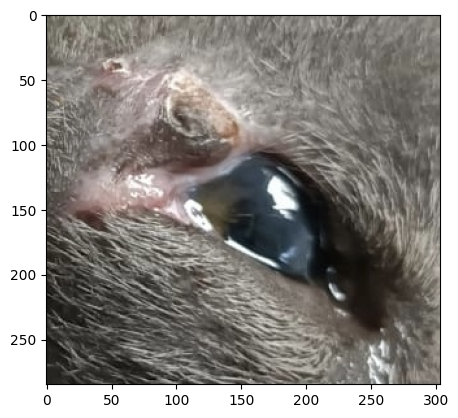

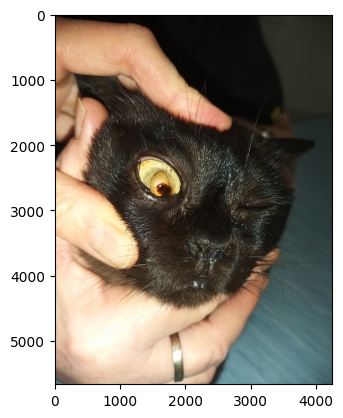

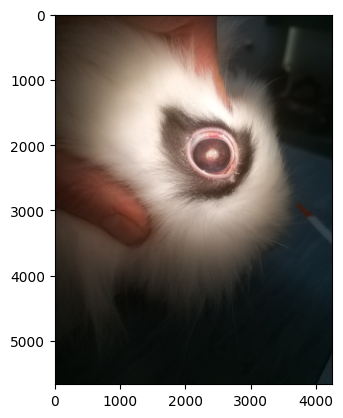

In [20]:
statistics_benchmark_images(df, statistics)

Let's explore the nature of each photo, and determine which ones are good, and which don't

<!-- In the manual for choosing a good picture it's stated that the eyeball should occupy at LEAST 30% of the picture.
- Some thoughts on seperating good pictures from bad: (Tiers of Cascading Classifier)
    - (Tier 1) We can use object detection of the eyeball only to classify the pictures, by the size of the surrounding rectangle.  
      I assume it will be a bit easier to implement / find ( George and Shai to the rescue 😜 )
    - (Tier 1.5) We can use classification model to try seperate between cats and dogs (cats will be supported later in the development).  
      Can be quite challenging since the eyeball occupies most of the picture area (see one tier above)
    - (Tier 2) We can use the specified landmarks that Victor described (EG Iris, Pupil, Sclera, ... ) to filter the images that do not fit (if they were not found) -->


**missions for today (6/2/2023) :**
- go over the photos and try to estimate the match factor for each one
    - instead of manually going over, try to adapt this code: [multiple images in a matplotlib example](https://www.geeksforgeeks.org/how-to-display-multiple-images-in-one-figure-correctly-in-matplotlib/)
    - Write some notes for the evening
- Talk with George about the model Anna mentioned
- Go over some articles about the topic
- Study the dog eye structure: this will help to come up with good/bad photo separation
    - Provide a Presentation with findings

## K level detail

In [22]:
# def quantize_img(img, levels):
#     from numpy import float32, uint8
#     from cv2 import kmeans, TERM_CRITERIA_EPS ,TERM_CRITERIA_MAX_ITER, KMEANS_RANDOM_CENTERS, cvtColor, COLOR_BGR2RGB
#     img_rgb = cvtColor(img, COLOR_BGR2RGB)
#     Z = img_rgb.reshape((-1,3))
#     # convert to np.float32
#     Z = float32(Z)
#     # define criteria, number of clusters(K) and apply kmeans()
#     criteria = (TERM_CRITERIA_EPS + TERM_CRITERIA_MAX_ITER, 10, 1.0)
#     K = 2
#     ret,label,center=kmeans(Z, levels,None,criteria,10,KMEANS_RANDOM_CENTERS)
#     # Now convert back into uint8, and make original image
#     center = uint8(center)
#     res = center[label.flatten()]
#     res2 = res.reshape((img.shape))
#     plt.imshow(res2)
#     plt.show()
#     plt.close()

In [23]:
# from numpy.random import seed as np_seed, choice
# from tqdm import tqdm, trange
# np_seed(0)
# img = choice(df.index, 1)[0]
# print(img)
# img = df.img[img]
# # for i in trange(0, 5):
# #     quantize_img(img, 2**(i+1))
# plt.imshow(cvtColor(img, COLOR_BGR2RGB))
# plt.show()
# plt.close()

47


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'
